# <center> Исследование данных HR-агентства

## Постановка задачи

HR-агентство изучает тренды на рынке труда в IT. Компания хочет провести исследование на основе данных о зарплатах в сфере Data Science за 2020–2022 годы и получить некоторые выводы.

Описание исходных данных:

- **work_year** - Год, в котором была выплачена зарплата.
- **experience_level** - Опыт работы на этой должности в течение года со следующими возможными значениями:
    * EN — Entry-level/Junior;
    * MI — Mid-level/Intermediate;
    * SE — Senior-level/Expert;
    * EX — Executive-level/Director.
- **employment_type** - Тип трудоустройства для этой роли:
    * PT — неполный рабочий день;
    * FT — полный рабочий день;
    * CT — контракт;
    * FL — фриланс.
- **job_title** - Роль, в которой соискатель работал в течение года.
- **salary** - Общая выплаченная валовая сумма заработной платы.
- **salary_currency** - Валюта выплачиваемой заработной платы в виде кода валюты ISO 4217.
- **salary_in_usd** - Зарплата в долларах США (валютный курс, делённый на среднее значение курса доллара США за соответствующий год через [fxdata.foorilla.com]).
- **employee_residence** - Основная страна проживания сотрудника в течение рабочего года в виде кода страны ISO 3166.
- **remote_ratio** - Общий объём работы, выполняемой удалённо. Возможные значения:
    * 0 — удалённой работы нет (менее 20 %);
    * 50 — частично удалённая работа;
    * 100 — полностью удалённая работа (более 80 %).
- **company_location** - Страна главного офиса работодателя или филиала по контракту в виде кода страны ISO 3166.
- **company_size** - Среднее количество людей, работавших в компании в течение года:
    * S — менее 50 сотрудников (небольшая компания);
    * M — от 50 до 250 сотрудников (средняя компания);
    * L — более 250 сотрудников (крупная компания).

Оригинальный датасет: [“Data Science Job Salaries” (kaggle.com)](https://www.kaggle.com/datasets/ruchi798/data-science-job-salaries)

Исследуйте данные и сделайте выводы по полученным результатам. Подкрепите свои рассуждения и выводы визуализациями и с помощью статистического тестирования проверьте, являются ли выводы статистически значимыми.

В процессе своего анализа вы должны выяснить, какие факторы влияют на зарплату специалиста Data Scientist.
А также ответить на ключевые вопросы HR-агентства:
- Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?
- Как соотносятся зарплаты Data Scientist и Data Engineer в 2022 году?
- Как соотносятся зарплаты специалистов Data Scientist в компаниях различных размеров?
- Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?

## Загрузка данных

In [508]:
import pandas as pd
import numpy as np

from scipy import stats
import statsmodels.api as sm
from statsmodels import stats as sms

import matplotlib.pyplot as plt
import seaborn as sns

import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

In [509]:
df_ds_salaries = pd.read_csv('./data/ds_salaries.csv', index_col=0)
df_ds_salaries.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L
1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S
2,2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,GB,M
3,2020,MI,FT,Product Data Analyst,20000,USD,20000,HN,0,HN,S
4,2020,SE,FT,Machine Learning Engineer,150000,USD,150000,US,50,US,L


In [510]:
# Уровень значимости
alpha = 0.05

## Описательный анализ данных

In [511]:
df_ds_salaries.info()
print(f'Количество пропущенных значений в исходных данных: {df_ds_salaries.isna().sum().sum()}')

<class 'pandas.core.frame.DataFrame'>
Index: 607 entries, 0 to 606
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           607 non-null    int64 
 1   experience_level    607 non-null    object
 2   employment_type     607 non-null    object
 3   job_title           607 non-null    object
 4   salary              607 non-null    int64 
 5   salary_currency     607 non-null    object
 6   salary_in_usd       607 non-null    int64 
 7   employee_residence  607 non-null    object
 8   remote_ratio        607 non-null    int64 
 9   company_location    607 non-null    object
 10  company_size        607 non-null    object
dtypes: int64(4), object(7)
memory usage: 56.9+ KB
Количество пропущенных значений в исходных данных: 0


Исходные данные содержат 607 записей, пропущенных значений нет.

In [512]:
print(f'Количество дубликатов: {df_ds_salaries.duplicated().sum()}')

# Удаление дубликатов
df_ds_salaries_cleared = df_ds_salaries.drop_duplicates()
print(f'Размерность таблицы после удаления дубликатов: {df_ds_salaries_cleared.shape}')

Количество дубликатов: 42
Размерность таблицы после удаления дубликатов: (565, 11)


После очистки исходных данных от дубликатов количество строк в датасете сократилось до 565.

### Предварительная подготовка

Определение типов признаков:  
- **work_year** (Год выплаты зарплаты) - числовой дискретный;
- **experience_level** (Опыт работы на должности в течение года) - порядковый категориальный;
- **employment_type** (Тип трудоустройства) - номинальный категориальный;
- **job_title** - (Роль, в которой соискатель работал в течение года) - номинальный категориальный;
- ~~*salary*~~ (Общая выплаченная валовая сумма заработной платы) - подлежит удалению;
- ~~*salary_currency*~~ (Валюта выплачиваемой заработной платы) - подлежит удалению;
- **salary_in_usd** (Зарплата в долларах США) - числовой непрерывный;
- **employee_residence** (Основная страна проживания сотрудника) - номинальный категориальный;
- **remote_ratio** (Общий объём работы, выполняемой удалённо) - порядковый категориальный (представлен в числовом виде);
- **company_location** (Страна главного офиса работодателя или филиала по контракту) - номинальный категориальный;
- **company_size** (Среднее количество людей, работавших в компании в течение года) - порядковый категориальный.

Признаки ~~*salary*~~ и ~~*salary_currency*~~ подлежат удалению, так как в датасете присутствует признак **salary_in_usd**, который уже объединяет в себе данные из них в единой валюте (USD).

In [513]:
# Удаление неинформативных признаков
df_ds_salaries_cleared = df_ds_salaries_cleared.drop(columns=['salary', 'salary_currency'],
                                                     axis=1)
# Перевод категориальных признаков в 'category'
df_ds_salaries_cleared['remote_ratio'] = df_ds_salaries_cleared['remote_ratio'].astype('category')
for col in df_ds_salaries_cleared.columns:
    if df_ds_salaries_cleared[col].dtype == 'object':
        df_ds_salaries_cleared[col] = df_ds_salaries_cleared[col].astype('category')

df_ds_salaries_cleared.info()
df_ds_salaries_cleared.head()

<class 'pandas.core.frame.DataFrame'>
Index: 565 entries, 0 to 606
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   work_year           565 non-null    int64   
 1   experience_level    565 non-null    category
 2   employment_type     565 non-null    category
 3   job_title           565 non-null    category
 4   salary_in_usd       565 non-null    int64   
 5   employee_residence  565 non-null    category
 6   remote_ratio        565 non-null    category
 7   company_location    565 non-null    category
 8   company_size        565 non-null    category
dtypes: category(7), int64(2)
memory usage: 25.2 KB


,work_year,experience_level,employment_type,job_title,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2020,MI,FT,Data Scientist,79833,DE,0,DE,L
1,2020,SE,FT,Machine Learning Scientist,260000,JP,0,JP,S
2,2020,SE,FT,Big Data Engineer,109024,GB,50,GB,M
3,2020,MI,FT,Product Data Analyst,20000,HN,0,HN,S
4,2020,SE,FT,Machine Learning Engineer,150000,US,50,US,L


### Основные статистические характеристики признаков

In [514]:
df_ds_salaries_cleared.describe().round(2)

,work_year,salary_in_usd
count,565.00,565.00
mean,2021.36,110610.34
std,0.70,72280.70
min,2020.00,2859.00
25%,2021.00,60757.00
50%,2021.00,100000.00
75%,2022.00,150000.00
max,2022.00,600000.00


In [515]:
df_ds_salaries_cleared.describe(include='category')

,experience_level,employment_type,job_title,employee_residence,remote_ratio,company_location,company_size
count,565,565,565,565,565,565,565
unique,4,4,50,57,3,50,3
top,SE,FT,Data Scientist,US,100,US,M
freq,243,546,130,295,346,318,290


## Разведывательный анализ данных

Так как ключевые вопросы HR-агентства связаны с конкретным упоминанием категории специалистов Data Scientist и Data Engineer, дальнейшее рассмотрение датасета производится с фильтрацией по данным значениям в признаке job_title.

In [516]:
# Фильтрация данных
mask_ds = df_ds_salaries_cleared['job_title'] == 'Data Scientist'
mask_de = df_ds_salaries_cleared['job_title'] == 'Data Engineer'
df_ds_salaries_cleared = df_ds_salaries_cleared[mask_ds | mask_de]
# Удаление неиспользуемых категорий в отфильтрованных данных
for col in df_ds_salaries_cleared.columns:
    if df_ds_salaries_cleared[col].dtype == 'category':
        df_ds_salaries_cleared[col] = df_ds_salaries_cleared[col].cat.remove_unused_categories()
# Сброс индексации записей
df_ds_salaries_cleared = df_ds_salaries_cleared.reset_index(drop=True)
# Реиндексация фильтров
mask_ds = df_ds_salaries_cleared['job_title'] == 'Data Scientist'
mask_de = df_ds_salaries_cleared['job_title'] == 'Data Engineer'

df_ds_salaries_cleared.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 251 entries, 0 to 250
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   work_year           251 non-null    int64   
 1   experience_level    251 non-null    category
 2   employment_type     251 non-null    category
 3   job_title           251 non-null    category
 4   salary_in_usd       251 non-null    int64   
 5   employee_residence  251 non-null    category
 6   remote_ratio        251 non-null    category
 7   company_location    251 non-null    category
 8   company_size        251 non-null    category
dtypes: category(7), int64(2)
memory usage: 6.5 KB


После фильтрации исходных данных количество строк в датасете сократилось до 251.

### Визуальный анализ данных

In [517]:
dict_col_name_rus = {'work_year': 'Год выплаты зарплаты',
                     'experience_level': 'Опыт работы на должности в течение года',
                     'employment_type': 'Тип трудоустройства',
                     'job_title': 'Роль, в которой соискатель работал в течение года',
                     'salary_in_usd': 'Зарплата в долларах США',
                     'employee_residence': 'Основная страна проживания сотрудника',
                     'remote_ratio': 'Общий объём работы, выполняемой удалённо',
                     'company_location': 'Страна главного офиса работодателя или филиала по контракту',
                     'company_size': 'Среднее количество людей, работавших в компании в течение года'}

#### Числовые признаки

In [518]:
for col in df_ds_salaries_cleared.columns:
    if df_ds_salaries_cleared[col].dtype in ['int64', 'float32']:
        # Инициализация полотна на два графика с общей осью X
        fig_col = make_subplots(rows=2, cols=1,
                                shared_xaxes=True, # Общая ось Х
                                x_title=dict_col_name_rus[col],
                                y_title='Количество',
                                row_heights=[0.15, 0.85], # Относительная высота полотен
                                subplot_titles=(f"Распределение признака <br>\"{dict_col_name_rus[col]}\"", ""),
                                vertical_spacing=0.02) # Высота разделителя
        # Построение коробчатой диаграммы
        fig_col.add_trace(go.Box(x=df_ds_salaries_cleared[col],
                                 marker_color = '#1729B0', # Цвет маркера
                                 jitter=0.5, # Разнос точек выбросов по вертикали
                                 name='',
                                 showlegend=False),
                          row=1, col=1)
        # Построение гистограммы
        fig_col.add_trace(go.Histogram(x=df_ds_salaries_cleared[col],
                                       marker_color = '#1729B0', # Цвет маркера
                                       name=dict_col_name_rus[col], # Название набора данных
                                       showlegend=False),
                          row=2, col=1)
        # Построение линии среднего значения
        fig_col.add_vline(x=df_ds_salaries_cleared[col].mean(),
                          line=dict(color="Red", dash='dash')) # Стиль линии
        # Размер полотна
        fig_col.update_layout(autosize = False, width = 1000, height = 620,
                              bargap=0.1) # Расстояние между столбцами гистограммы
        fig_col.show()
        
        display(df_ds_salaries_cleared[col].describe().round(2))

count     251.00
mean     2021.45
std         0.71
min      2020.00
25%      2021.00
50%      2022.00
75%      2022.00
max      2022.00
Name: work_year, dtype: float64

count       251.00
mean     106428.21
std       61219.17
min        2859.00
25%       62096.50
50%      100000.00
75%      144500.00
max      412000.00
Name: salary_in_usd, dtype: float64

Признак **'Год выплаты зарплаты'**:  
Числовой признак является дискретным, количество значений равно трем, а промежутки между ними равны, что позволяет рассматривать его как порядковый категориальный. Количество записей возрастает с увеличением года.  
При рассмотрении года выплаты зарплаты следует отметить достаточно малое количество данных за 2020 год.

Признак **'Зарплата в долларах США'**:  
Является целевым признаком в рассматриваемых вопросах. Из формы гистограммы и неравенства среднего значения зарплаты и ее медианы следует, что распределение значений отлично от нормального, а именно является правосторонним скошенным, что означает, что большая часть данных сосредоточена в нижнем диапазоне, а небольшая часть специалистов является высокооплачиваемыми. Форма коробчатой диаграммы свидетельствует о наличии выбросов, где зарплата значительно превышает медиану. Эти данные могут быть связаны с высокооплачиваемыми руководителями или специалистами.

#### Категориальные признаки

In [519]:
for col in df_ds_salaries_cleared.columns:
    if df_ds_salaries_cleared[col].dtype == 'category':
        # Инициализация полотна на два графика с общей осью X
        fig_col = go.Figure(data=go.Bar(x=df_ds_salaries_cleared[col].value_counts().index.astype(str),
                                        y=df_ds_salaries_cleared[col].value_counts()))
        # Размер полотна
        fig_col.update_layout(autosize = False, width = 800, height = 400)
        # Заголовок диаграммы
        fig_col.update_layout(title=f"Распределение признака <br>\"{dict_col_name_rus[col]}\"",
                              title_x=0.5, # Расположение посередине
                              xaxis_title=dict_col_name_rus[col], # Подпись Х
                              yaxis_title='Количество') # Подпись Y
        fig_col.show()
        
        display(df_ds_salaries_cleared[col].describe())
        display(df_ds_salaries_cleared[col].value_counts(normalize=True).head(5).round(4)*100)

count     251
unique      4
top        MI
freq      110
Name: experience_level, dtype: object

experience_level
MI    43.82
SE    41.04
EN    13.55
EX     1.59
Name: proportion, dtype: float64

count     251
unique      3
top        FT
freq      245
Name: employment_type, dtype: object

employment_type
FT    97.61
PT     1.59
FL     0.80
Name: proportion, dtype: float64

count                251
unique                 2
top       Data Scientist
freq                 130
Name: job_title, dtype: object

job_title
Data Scientist    51.79
Data Engineer     48.21
Name: proportion, dtype: float64

count     251
unique     33
top        US
freq      138
Name: employee_residence, dtype: object

employee_residence
US    54.98
GB    11.16
IN     4.38
FR     3.98
DE     3.19
Name: proportion, dtype: float64

count     251
unique      3
top       100
freq      150
Name: remote_ratio, dtype: int64

remote_ratio
100    59.76
0      25.90
50     14.34
Name: proportion, dtype: float64

count     251
unique     29
top        US
freq      147
Name: company_location, dtype: object

company_location
US    58.57
GB    11.95
IN     3.98
DE     3.98
FR     3.59
Name: proportion, dtype: float64

count     251
unique      3
top         M
freq      147
Name: company_size, dtype: object

company_size
M    58.57
L    30.68
S    10.76
Name: proportion, dtype: float64

Признак **'Опыт работы на должности в течение года'**:  
Преобладает категория SE (Senior-level/Expert), за ней следует MI (Mid-level/Intermediate) и EN (Entry-level/Junior), наименьшее количество в категории EX (Executive-level/Director).  
Опыт работы на должности в течение года должен быть значимым для анализа зарплат.

Признак **'Тип трудоустройства'**:  
Явно преобладает категория FT (полный рабочий день), категории PT (неполный рабочий день) и FL (фриланс) крайне малы и сопоставимы по своему количеству между собой.  
Тип трудоустройства должен быть значимым при анализе заработной платы, однако, в данной выборке категория FT встречается в более чем 97% записей, записей по остальным категориям достаточно мало, поэтому выводы по ним могут быть недостоверны.

Признак **'Роль, в которой соискатель работал в течение года'**:  
По данному признаку была произведена фильтрация данных из исходного набора. В текущем состоянии признак содержит две категории: Data Scientist и Data Engineer, количество записей в Data Scientist преобладает незначительно, соответсвенно категории сопоставимы между собой, что позволяет провести корректный анализ по ключевым вопросам HR-агентства, в которых фигурирует сравнение показателей специалистов Data Scientist и Data Engineer.

Признак **'Основная страна проживания сотрудника'**:  
Наибольшая доля приходится на US (США) и GB (Великобритания) со значительным преобладанием US. Остальные 34% записей распределены в другой 31 категории признака.  
Страна проживания сотрудника может оказывать значительное влияние на размер его заработной платы.

Признак **'Общий объём работы, выполняемой удалённо'**:  
Преобладает категория 100 (полностью удалённая работа), за ней следует 0 (удалённой работы нет), наименьшее количество в категории 50 (частично удалённая работа).  
Общий объём работы, выполняемой удалённо, должен быть значимым для анализа зарплат.

Признак **'Страна главного офиса работодателя или филиала по контракту'**:  
Наибольшая доля приходится на US (США) и GB (Великобритания) со значительным преобладанием US. Остальные 30% записей распределены в других 27 категориях признака.  
Страна главного офиса работодателя может оказывать значительное влияние на размер его заработной платы.

Признак **'Среднее количество людей, работавших в компании в течение года'**:  
Преобладает категория M (средняя компания), за ней следует L (крупная компания), наименьшее количество в категории S (небольшая компания).  
Размер компании должен быть значимым для анализа зарплат.

#### Ключевые вопросы

##### 1. Размер заработной платы у специалистов Data Scientist по годам

In [520]:
# Инициализация полотна
figure_salary_ds = make_subplots(rows=2, cols=1,
                                 subplot_titles=("Медиана заработной платы DS в 2020-2022 гг.", 
                                                 "Распределение заработной платы DS в 2020-2022 гг."),
                                 row_heights=[0.3, 0.7],
                                 vertical_spacing=0.15)
# Подготовка данных для отображения
df_median_salaries_DS = df_ds_salaries_cleared[mask_ds].groupby(by=['work_year'])['salary_in_usd'].median()
# Отрисовка баров
figure_salary_ds.add_trace(go.Bar(x=df_median_salaries_DS.index.astype(str),
                                  y=df_median_salaries_DS,
                                  showlegend=False,
                                  marker_color = '#10c938'), # Цвет маркера
                            row=1, col=1)
# Построение коробчатой диаграммы
for year in df_median_salaries_DS.index:
    mask_year = df_ds_salaries_cleared['work_year'] == year
    figure_salary_ds.add_trace(go.Box(y=df_ds_salaries_cleared[mask_ds & mask_year]['salary_in_usd'],
                                      showlegend=False,
                                      name=year), # Название набора данных
                               row=2, col=1)
# Размер полотна
figure_salary_ds.update_layout(autosize = False, width = 800, height = 570,
                               title='Размер заработной платы специалистов Data Scientist в 2020-2022 годах',
                               title_x=0.5) # Выравнивание заголовка посередине 
# Подпись осей
figure_salary_ds.update_xaxes(title_text="Год", row = 2, col = 1)
figure_salary_ds.update_yaxes(title_text="ЗП, $", row = 1, col = 1)
figure_salary_ds.update_yaxes(title_text="Заработная плата, $", row = 2, col = 1)
figure_salary_ds.show()

Здесь и для последующих расчетов из-за отсутствия признаков нормального распределения в данных о заработной плате в качестве меры центральной тенденции выбрана медиана значений.
Исходя из полученных графиков, у специалистов Data Scientist наблюдается ежегодный рост зарплат.

##### 2. Соотношение заработной платы Data Scientist и Data Engineer в 2022 году

In [521]:
# Инициализация полотна
figure_salary_ds_de = make_subplots(rows=2, cols=1,
                                    subplot_titles=("Медиана заработной платы DS и DE в 2022 г.", 
                                                    "Распределение заработной платы DS и DE в 2022 г."),
                                    row_heights=[0.3, 0.7],
                                    vertical_spacing=0.15)
# Подготовка данных для отображения
mask_2022 = df_ds_salaries_cleared['work_year'] == 2022
df_median_salaries_2022 = df_ds_salaries_cleared[mask_2022].groupby(by=['job_title'], observed=True)['salary_in_usd'].median()
# Отрисовка баров
figure_salary_ds_de.add_trace(go.Bar(x=df_median_salaries_2022.index,
                                     y=df_median_salaries_2022,
                                     showlegend=False),
                              row=1, col=1)
# Построение коробчатой диаграммы
for title in df_median_salaries_2022.index:
    mask_title = df_ds_salaries_cleared['job_title'] == title
    figure_salary_ds_de.add_trace(go.Box(y=df_ds_salaries_cleared[mask_title & mask_2022]['salary_in_usd'],
                                         showlegend=False,
                                         name=title), # Название набора данных
                                  row=2, col=1)
# Размер полотна
figure_salary_ds_de.update_layout(autosize = False, width = 800, height = 570,
                               title='Размер заработной платы специалистов Data Scientist в 2020-2022 годах',
                               title_x=0.5) # Выравнивание заголовка посередине 
# Подпись осей
figure_salary_ds_de.update_xaxes(title_text="Специалист", row = 2, col = 1)
figure_salary_ds_de.update_yaxes(title_text="ЗП, $", row = 1, col = 1)
figure_salary_ds_de.update_yaxes(title_text="Заработная плата, $", row = 2, col = 1)
figure_salary_ds_de.show()

Исходя из полученных графиков, в 2022 году заработная плата специалистов Data Scientist выше, чем у специалистов Data Engineer.

##### 3. Соотношение заработной платы специалистов Data Scientist в компаниях различных размеров

In [522]:
# Инициализация полотна
figure_salary_ds_size_copm = make_subplots(rows=2, cols=1,
                                           subplot_titles=("Медиана заработной платы DS в компаниях различного размера", 
                                                         "Распределение заработной платы DS в компаниях различного размера"),
                                           row_heights=[0.3, 0.7],
                                           vertical_spacing=0.15)
# Подготовка данных для отображения
df_median_salaries_ds_size_copm = df_ds_salaries_cleared[mask_ds].groupby(by=['company_size'], observed=True)['salary_in_usd'].median()
# Отрисовка баров
figure_salary_ds_size_copm.add_trace(go.Bar(x=df_median_salaries_ds_size_copm.index,
                                            y=df_median_salaries_ds_size_copm,
                                            showlegend=False),
                                     row=1, col=1)
# Построение коробчатой диаграммы
for size in df_median_salaries_ds_size_copm.index:
    mask_size = df_ds_salaries_cleared['company_size'] == size
    figure_salary_ds_size_copm.add_trace(go.Box(y=df_ds_salaries_cleared[mask_size & mask_ds]['salary_in_usd'],
                                                showlegend=False,
                                                name=size), # Название набора данных
                                         row=2, col=1)
# Размер полотна
figure_salary_ds_size_copm.update_layout(autosize = False, width = 800, height = 570,
                               title='Размер заработной платы специалистов Data Scientist в компаниях различного размера',
                               title_x=0.5) # Выравнивание заголовка посередине 
# Подпись осей
figure_salary_ds_size_copm.update_xaxes(title_text="Размер компании", row = 2, col = 1)
figure_salary_ds_size_copm.update_yaxes(title_text="ЗП, $", row = 1, col = 1)
figure_salary_ds_size_copm.update_yaxes(title_text="Заработная плата, $", row = 2, col = 1)
figure_salary_ds_size_copm.show()

Распределение заработной платы специалистов Data Scientist в компаниях с разным штатом сотрудников различаются, при этом наиболее высокая зарплата ожидается в средних компаниях, такое различие по сравнению с крупными компаниями может объясняться наличием в крупных компаниях расширенных социальных гарантий и развитой дополнительной социальной инфраструктуры для своих сотрудников (спорт-залы, зоны отдыха и т.п.), а также, возможно, в крупных и средних компаниях масштабы решаемых задач соразмерны, но ввиду количества сотрудников, решающих их, итоговая нагрузка на каждого специалиста в отдельности в средних компаниях выше.

##### 4. Связь между наличием должностей Data Scientist и Data Engineer и размером компании

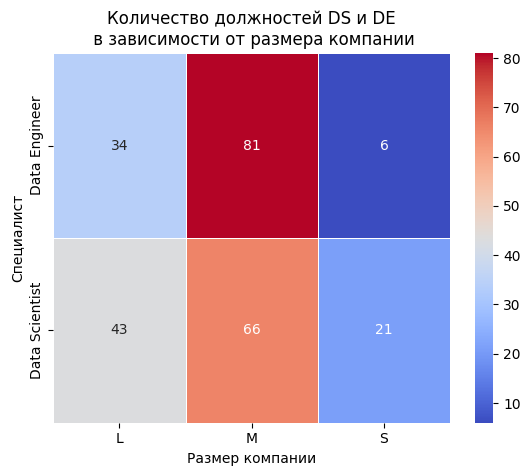

In [523]:
cross_tab = pd.crosstab(index=df_ds_salaries_cleared['job_title'], 
                        columns=df_ds_salaries_cleared['company_size'])
ax = sns.heatmap(cross_tab, annot=True, linewidth=.5, fmt='.0f', cmap="coolwarm")
ax.set(xlabel='Размер компании', ylabel='Специалист')
plt.title('Количество должностей DS и DE\n в зависимости от размера компании')
plt.show()

Согласно тепловой карте наибольшее количество специалистов Data Scientist и Data Engineer наблюдается в средних компаниях, причем количество специалистов Data Engineer имеет максимальное значение. При этом минимальное значение наблюдается также у специалистов этой категории в малых компаниях.

#### Обзор взаимосвязи заработной платы специалистов с остальными признаками

##### 1. Зависимость размера заработной платы от опыта работы на должности в течение года

In [524]:
# Инициализация полотна
figure_salaries_experience = make_subplots(rows=2, cols=1,
                                           subplot_titles=("Медиана размера заработной платы специалистов в зависимости <br>\
от опыта работы на должности в течение года", 
                                                          "Распределение размера заработной платы специалистов в зависимости <br>\
от опыта работы на должности в течение года"),
                                           row_heights=[0.3, 0.7],
                                           vertical_spacing=0.15)
# Построение баров
figure_salaries_experience.add_trace(go.Bar(x=df_ds_salaries_cleared.groupby('experience_level', observed=True)['salary_in_usd'].median().index,
                                            y=df_ds_salaries_cleared.groupby('experience_level', observed=True)['salary_in_usd'].median(),
                                            showlegend=False,
                                            name='Опыт работы на должности в течение года',
                                            marker_color = '#FF9700'), # Цвет маркера
                                     row=1, col=1)

# Построение коробчатой диаграммы
for cat in df_ds_salaries_cleared['experience_level'].unique():
    figure_salaries_experience.add_trace(go.Box(y=df_ds_salaries_cleared[df_ds_salaries_cleared['experience_level'] == cat]['salary_in_usd'],
                                                showlegend=False,
                                                name=cat), # Название набора данных
                                         row=2, col=1)
# Размер полотна
figure_salaries_experience.update_layout(autosize = False, width = 800, height = 570,
                                        title='Зависимость размера заработной платы от опыта работы на должности в течение года',
                                        title_x=0.5) # Выравнивание заголовка посередине
# Порядок вывода категорий
figure_salaries_experience.update_xaxes(categoryorder='array',
                                        categoryarray=["EN", "MI", "SE", "EX"])   
# Подпись осей
figure_salaries_experience.update_xaxes(title_text="Опыт работы на должности в течение года", row = 2, col = 1)
figure_salaries_experience.update_yaxes(title_text="ЗП, $.", row = 1, col = 1)
figure_salaries_experience.update_yaxes(title_text="Заработная плата, $", row = 2, col = 1)

figure_salaries_experience.show()

Наблюдается прямая зависимость размера заработной платы от опыта работы на должности в течение года: с возрастанием опыта работы заработная плата также растет.

##### 2. Зависимость размера заработной платы от типа трудоустройства

In [525]:
# Инициализация полотна
figure_salaries_employment = make_subplots(rows=2, cols=1,
                                           subplot_titles=("Медиана размера заработной платы специалистов в зависимости <br>\
от типа трудоустройства", 
                                                          "Распределение размера заработной платы специалистов в зависимости <br>\
от типа трудоустройства"),
                                           row_heights=[0.3, 0.7],
                                           vertical_spacing=0.15)
# Построение баров
figure_salaries_employment.add_trace(go.Bar(x=df_ds_salaries_cleared.groupby('employment_type', observed=True)['salary_in_usd'].median().index,
                                            y=df_ds_salaries_cleared.groupby('employment_type', observed=True)['salary_in_usd'].median(),
                                            showlegend=False,
                                            name='Тип трудоустройства',
                                            marker_color = '#00A876'), # Цвет маркера
                                     row=1, col=1)

# Построение коробчатой диаграммы
for cat in df_ds_salaries_cleared['employment_type'].unique():
    figure_salaries_employment.add_trace(go.Box(y=df_ds_salaries_cleared[df_ds_salaries_cleared['employment_type'] == cat]['salary_in_usd'],
                                                showlegend=False,
                                                name=cat), # Название набора данных
                                         row=2, col=1)
# Размер полотна
figure_salaries_employment.update_layout(autosize = False, width = 800, height = 570,
                                        title='Зависимость размера заработной платы от типа трудоустройства',
                                        title_x=0.5) # Выравнивание заголовка посередине
# Порядок вывода категорий
figure_salaries_employment.update_xaxes(categoryorder='array',
                                        categoryarray=["FL", "PT", "FT"])   
# Подпись осей
figure_salaries_employment.update_xaxes(title_text="Тип трудоустройства", row = 2, col = 1)
figure_salaries_employment.update_yaxes(title_text="ЗП, $.", row = 1, col = 1)
figure_salaries_employment.update_yaxes(title_text="Заработная плата, $", row = 2, col = 1)

figure_salaries_employment.show()

Медианные значения заработной платы специалистов Data Scientist и Data Engineer в категориях FL (фриланс) и PT (неполный рабочий день) позволяют предположить равенство зарплат при данных типах трудоустройства, для FT (полный рабочий день) это значение выше, но распределение в данной категории захватывает полный спектр значений для остальных двух категорий, диаграммы распределений категорий FL и PT также различны, что показывает необходимость в проведении статистических тестов.

##### 3. Зависимость размера заработной платы от общего объёма работы, выполняемой удалённо

In [526]:
# Инициализация полотна
figure_salaries_remote_ratio = make_subplots(rows=2, cols=1,
                                             subplot_titles=("Медиана размера заработной платы специалистов в зависимости <br>\
от общего объёма работы, выполняемой удалённо", 
                                                             "Распределение размера заработной платы специалистов в зависимости <br>\
от общего объёма работы, выполняемой удалённо"),
                                             row_heights=[0.3, 0.7],
                                             vertical_spacing=0.15)
# Построение баров
figure_salaries_remote_ratio.add_trace(go.Bar(x=df_ds_salaries_cleared.groupby('remote_ratio', observed=True)['salary_in_usd'].median().index.astype('str'),
                                              y=df_ds_salaries_cleared.groupby('remote_ratio', observed=True)['salary_in_usd'].median(),
                                              showlegend=False,
                                              name='Общий объём работы, выполняемой удалённо',
                                              marker_color = '#00A876'), # Цвет маркера
                                       row=1, col=1)
# Построение коробчатой диаграммы
for cat in df_ds_salaries_cleared['remote_ratio'].unique():
    figure_salaries_remote_ratio.add_trace(go.Box(y=df_ds_salaries_cleared[df_ds_salaries_cleared['remote_ratio'] == cat]['salary_in_usd'],
                                                  showlegend=False,
                                                  name=cat), # Название набора данных
                                           row=2, col=1)
# Размер полотна
figure_salaries_remote_ratio.update_layout(autosize = False, width = 800, height = 570,
                                          title='Зависимость размера заработной платы от общего объёма работы, выполняемой удалённо',
                                          title_x=0.5) # Выравнивание заголовка посередине
# Подпись осей
figure_salaries_remote_ratio.update_xaxes(title_text="Общий объём работы, выполняемой удалённо", row = 2, col = 1)
figure_salaries_remote_ratio.update_yaxes(title_text="ЗП, $.", row = 1, col = 1)
figure_salaries_remote_ratio.update_yaxes(title_text="Заработная плата, $", row = 2, col = 1)

figure_salaries_remote_ratio.show()

Медианные значения заработной платы специалистов Data Scientist и Data Engineer при всех вариантах объема работы, выполняемой удаленно, различны. При этом минимальное значение наблюдается в категории 50 (частично удаленная работа), максимальное - в категории 100 (полностью удалённая работа).

##### 4. Зависимость размера заработной платы сотрудников, проживающих в стране главного офиса работодателя, и сотрудников, проживающих за ее пределами

In [530]:
# Подготовка данных для отображения
df_median_salaries_us = df_ds_salaries_cleared[['salary_in_usd', 'job_title', 'employee_residence']].copy()
df_median_salaries_us['employee_residence'] = df_median_salaries_us['employee_residence'].astype(str)
df_ds_salaries_cleared['company_location'] = df_ds_salaries_cleared['company_location'].astype(str)
# Создание признака совпадения страны проживания и страны работодателя
df_median_salaries_us['company_loc_is_empl_residence'] = np.where(df_median_salaries_us['employee_residence'] == df_ds_salaries_cleared['company_location'],
                                                                           'Совпадает', 'Не совпадает')
# Подготовка данных для отображения
pt_us = df_median_salaries_us.groupby(by=['job_title', 'company_loc_is_empl_residence'], observed=True, as_index=False)['salary_in_usd'].median()
pt_us.rename(columns={"job_title": "Специалист", 
                      "company_loc_is_empl_residence": "Страна работодателя и проживания", 
                      "salary_in_usd": "Заработная  плата"},
             inplace=True)
# Построение баров
figure_salary_us= px.bar(data_frame=pt_us,
                         y='Страна работодателя и проживания',
                         x='Заработная  плата',
                         barmode="group",
                         orientation='h',
                         color='Специалист')
figure_salary_us.update_layout(autosize = False, width = 800, height = 430, # Размер полотна
                               bargap=0.3) # Расстояние между столбцами
# Заголовк и подписи осей
figure_salary_us.update_layout(title='Медиана заработной платы сотрудников компаний,<br>\
работающих в одной стране и за ее пределами',
                               title_x=0.5) # Выравнивание заголовка посередине
figure_salary_us.show()

При рассмотрении уровня заработной платы сотрудников компании, работающих в стране главного офиса работодателя и за ее пределами, прослеживается закономерность, что при найме сотрудников за пределами страны главного офиса работодателя заработная плата значительно ниже. При этом разница между зарплатами Data Scientist и Data Engineer не столь существенна. Данный факт может быть связан с тем, что в большинстве случаев компании обеспечивают средний уровень заработной платы по стране ее расположения и не нанимает сотрудников за ее пределами в странах с более высоким уровнем доходов, а наоборот, ищет сотрудников в странах с меньшим средним уровнем зарплаты, что позволяет ей сэкономить, даже предложив более высокую зарплату, чем средняя по стране проживания соискателя.

Таким образом, на заработную плату влияют следующие факторы:
- роль, в которой соискатель работал в течении года;
- размер компании;
- опыта работы на должности в течение года;
- тип трудоустройства;
- режим работы (общий объём работы, выполняемой удалённо);
- является ли страна работодателя страной проживания сотрудника;
- также ежегодно заработная плата увеличивается.

### Статистический анализ данных

#### Ключевые вопросы

##### 1. Размер заработной платы у специалистов Data Scientist по годам

В ходе визуального ...

##### 2. Соотношение заработной платы Data Scientist и Data Engineer в 2022 году

В ходе визуального ...

##### 3. Соотношение заработной платы специалистов Data Scientist в компаниях различных размеров

В ходе визуального ...

##### 4. Связь между наличием должностей Data Scientist и Data Engineer и размером компании

В ходе визуального ...

#### Обзор взаимосвязи заработной платы специалистов с остальными признаками

##### 1. Зависимость размера заработной платы от опыта работы на должности в течение года

В ходе визуального ...

##### 2. Зависимость размера заработной платы от типа трудоустройства

В ходе визуального ...

##### 3. Зависимость размера заработной платы от общего объёма работы, выполняемой удалённо

В ходе визуального ...

##### 4. Зависимость размера заработной платы сотрудников, проживающих в стране главного офиса работодателя, и сотрудников, проживающих за ее пределами

В ходе визуального ...

## Итоговый вывод




Отметить, что для получения более достоверных данных по признакам "по году", "по типу трудоустройства" необходимо получение большего количества наблюдений за 2020 год и ХХХ и ХХХ категориях типа трудоустройства